# YouTube API Lab - Part 1: Channel Specific Data Collection
## Introduction

In this lab, we will familiarize ourselves with the YouTube API. By completing this lab, you should be able to:
* Collect summary information for one or more YouTube channels
* Gather data on the channel's uploaded videos
* Gather samples of comments from each video
* Navigate and use code documentation

Some code/Python skills used in this lab include: dictionaries, JSON, while loops, try/except, and pandas Dataframes

**NOTE:** This lab is _HEAVILY_ based on [this video](https://www.youtube.com/watch?v=D56_Cx36oGY). A lot of the code comes directly from it, but it works perfectly well for our purposes. Feel free to watch it yourself for a more guided walkthrough of the process (especially setting up your API key).

### Pre-requisites
- Install the `google-api-python-client` package with the code below or directly in your terminal

In [56]:
#%pip install --upgrade google-api-python-client 

In [57]:
from googleapiclient.discovery import build
import pandas as pd

To simulate a project, we'll be focusing on analyzing a case study of controversy as it affects one YouTuber. More context will be provided in the next part, but for now, the channel is that of [Gus Johnson](https://www.youtube.com/@gustoonz) and our main question is: **How has controversy affected the metric performance of Gus Johnson's YouTube Channel?**
## Gus Johnson - Youtuber Analytic Performance In the Face of Controversy

### Connecting to the API
Your first goal in most API accesses is to get an API key - an access code that allows you to send requests to and from the platform. To get that API key, you'll need to:
* Log into Google API Console
* Create and set up a new project
* Get credentials 
* Create a new key

There are many guides to walk you through this process including 
* A document uploaded for you in Canvas <- I would start with this one
* the [official quickstart guide](https://developers.google.com/youtube/v3/quickstart/python) 
* or the previously mentioned [YouTube video](https://www.youtube.com/watch?v=D56_Cx36oGY)

In [58]:
api_key = "<YOUR API KEY>" #REMEMBER TO REMOVE BEFORE UPLOADING
api_service_name = "youtube"
api_version = "v3"

In [59]:
#Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key
)

## Collecting Channel Info

The first step is to extract our channel of interest. 
<br><br>
We can start with finding the channel username in the URL of the channel page. We want what comes after the '@' <br>
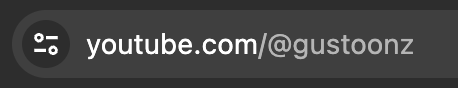


In [60]:
channel_user = "gustoonz" # <- Save the ID to a variable

Using the channel ID, we can make a request to the API in this format: (Note the structure of the request - this pattern repeats for almost every request we're going to make to this API)

In [ ]:
request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    forUsername=channel_user
)

response = request.execute()

response

As you can see, the response is a JSON of channel attributes. We don't necessesarily want all of this, so let's simplify it out. 

#### Try it yourself

Create a function that extracts the following information from an inputted channel username (I recommend making a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)):
* Name
* Channel Creation Date
* Subscriber Count
* View Count
* Upload Count
* ID of their uploads playlist <- This will allow us to look at their uploads later

**HINT**: Look closely at the structure of the JSON object. Track what attributes are nested under other categories.

In [84]:
def get_channel_info(username):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        forUsername=username
    )

    response = request.execute()

    # Your solution

In [85]:
# Test your code:

channel_info = get_channel_info(channel_user)
channel_info

{'channelName': 'Gus Johnson',
 'channelStartDate': '2010-09-11T20:11:40Z',
 'subscribers': '3030000',
 'viewCount': '986414437',
 'videoCount': '749',
 'uploadsPlaylist': 'UUpIafFPGutTAKOBHMtGen7g'}

## Get All Uploads

Now that we've gotten our basic channel info, we can start to collect data on what they're uploading. This is where we use that playlist ID we collected to get the IDs of every video this channel has published.

To get practice using [documentation](https://developers.google.com/youtube/v3/docs), see if you can find the code to get information on items in a playlist. 

In [64]:
# Your Solution

You might notice that the maximum number of videos you can get from the playlist is 50. Gus Johnson and most other large YouTubers have uploaded more than that. This is where we use the "next page token". <br>
Here we can see a while loop that collects the "address" of the next page of data for as long as there is a page to go to. 

In [65]:
# Create a list to store video IDs in
video_ids = []
# Add our first page to the list
video_ids.extend([item['contentDetails']['videoId'] for item in response['items']])

next_page = response.get('nextPageToken')


while next_page is not None: 
    request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        playlistId = channel_info['uploadsPlaylist'],
        maxResults = 50,
        pageToken = next_page # The page token goes here
    )
    response = request.execute()

    video_ids.extend([item['contentDetails']['videoId'] for item in response['items']])
    next_page = response.get('nextPageToken')

len(video_ids) # Check to see if this length matches the upload count collected above

750

### Video Information Queries
Now that we've collected the video IDs, we can query each one for its own information. 

The below code uses a for loop to request information in batches. This practice is commonly used to avoid limits on how many requests one user can make at once to an API (aka a **limit** on the **rate** at which you can make requests)

In [66]:
def get_video_data(video_ids):
    video_data = []
    for i in range (0, len(video_ids), 50): # performs requests in batches to avoid rate-limiting
        request = youtube.videos().list(
            part='snippet,contentDetails,statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for item in response['items']:
            relevant_stats = {
                'snippet': ['title', 'description', 'tags', 'publishedAt'], 
                'statistics': ['viewCount', 'likeCount', 'commentCount'], 
                'contentDetails': ['duration', 'definition', 'caption']
            }

            video_info = {}
            video_info['video_id'] = item['id']

            for cat in relevant_stats.keys():
                for stat in relevant_stats[cat]:
                    try:
                        video_info[stat] = item[cat][stat]
                    except:
                        video_info[stat] = None

            video_data.append(video_info)
    video_data
    return pd.DataFrame(video_data)

In [67]:
videos_df = get_video_data(video_ids)

In [68]:
videos_df

,video_id,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,mARBxshkQ3Q,your friend who got scammed,↓CHECK THIS OUT↓\n- Instagram: https://www.ins...,"[gus, gus johnson, gus johnson update, gus joh...",2024-03-13T20:32:21Z,204402,15652,363,PT4M49S,hd,false
1,eckwAcmtfx8,Didn't think I'd have to have this talk...,↓CHECK THIS OUT↓\n- Instagram: https://www.ins...,"[i didnt want to have this talk, gus johnson, ...",2024-02-19T22:52:36Z,163779,10219,288,PT3M33S,hd,false
2,5zHh6Ax8vBs,I wrote the Josh Wine national anthem,SONG ABOUT JOSH WINE\n↓CHECK THIS OUT↓\n- Inst...,"[last night we let the josh talk, josh talk, j...",2024-01-22T22:53:16Z,165196,9381,544,PT1M28S,hd,false
3,PEFgnSp9z0A,somebody stop him,↓CHECK THIS OUT↓\n- Instagram: https://www.ins...,"[gus, gus johnson, gus johnson 2024, gus johns...",2024-01-09T22:30:21Z,184879,15521,528,PT1M56S,hd,false
4,fO66jBPnd-s,my neighbor is ruining my life,↓CHECK THIS OUT↓\n- Instagram: https://www.ins...,"[gus, gus johnson, gus johnson update, gus joh...",2023-12-08T19:38:57Z,245948,22666,472,PT1M34S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...
745,iczMOqlQmn8,Exaggerated Weather Reporting,"""I Spy News"" goes live on the scene to over-th...","[exaggerated, weather, reporting, exaggerate, ...",2010-12-23T22:20:58Z,51585,2186,194,PT3M43S,hd,false
746,rFKq49tOMyQ,Fanfight,Dispute over a fan.,"[fanfight, fan, fight, outside, ouch, flour]",2010-11-11T02:28:13Z,32356,1204,98,PT1M50S,hd,false
747,QV_EKHmGlfM,How To Kill a Mockingbird,A lazy Sunday afternoon of building card house...,"[how to kill a mockingbird, gustoonz, gus, too...",2010-11-11T02:17:43Z,123633,4074,295,PT3M4S,hd,false
748,3DVNS_skRLo,Light Your World,A peaceful meditation process encounters some ...,"[carry your candle, candle, carry, your, hot, ...",2010-10-28T00:33:42Z,80667,2566,224,PT2M26S,hd,false


## Your Final Task for Part 1 - Make this Reusable

You might need to get this info for multiple channels, and manually running all of this code would be inefficient. Let's take all of the above work we've done and turn it into one function call that:
- Accepts a channel username
- Returns a dict with channel info and a dataframe with upload data

**HINT**: Don't try to make one really long function. Since a lot of our code is already structured in functions, call them as helper functions in this new one (see example). You'll need to make one `get_video_ids` function on your own based on the above code

For Example:
```python
def largeTask(x):
    a = stepOne(x)

    b = stepTwo(a)

    return b
```

In [86]:
# Define any helper functions here

In [87]:
def get_channel_data(username):
    # Your Solution

In [88]:
# Test your code (Try out a few of your favorite channels!)
info, uploads = get_channel_data('gustoonz')

print(info)
uploads

## BONUS - Getting Comments

Another way to measure reception of a video beyond the likes and views is the comments the audience leaves. We can do all kinds of text analysis with this data later on.

This method uses something called a [try/except](https://docs.python.org/3/tutorial/errors.html#handling-exceptions) which basically runs the code in the try section, but if any errors occur it switches to the except section. Here, the function attempts to collect comment data on an inputted list of videos, but if one or more videos have comments disabled the code prints out 'Could not get comments for video {video_id}' instead of stopping the program.

In [79]:
def get_comments_in_videos(video_ids, maxLimit=15):
    all_comments = []
    
    for video_id in video_ids[:maxLimit]:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            print('Could not get comments for video ' + video_id)

    return pd.DataFrame(all_comments)

In [80]:
get_comments_in_videos(videos_df['video_id'])

,video_id,comments
0,mARBxshkQ3Q,[The song at the end of every video sped up 2x...
1,eckwAcmtfx8,"[Hands the kids glass 😂😂😂, Believe it or not, ..."
2,5zHh6Ax8vBs,"[Now do when the egg roll is called up yonder,..."
3,PEFgnSp9z0A,[I've never googled potato salad before. $18 f...
4,fO66jBPnd-s,[I like how at the end he walks directly into ...
5,FhqG0X1rBuw,"[This is the best., The way he’s just like a k..."
6,YpLB1-EZM7o,"[Definitely cut from the same cloth, me and Gu..."
7,45RAMWRHsZQ,[I need money. You need employee. Let's make t...
8,QfyJxkjdJnw,"[As a Michigander, I have done literally every..."
9,vgMJ7Pp7fnA,[I like that sweet Red Owl merch. He musta had...
